In [1]:
import pandas as pd
import numpy as np
import malariagen_data
import allel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
ag3 = malariagen_data.Ag3(
    sample_sets="3.3",
    debug=False,
    show_progress=True
)

In [4]:
samples = ag3.sample_metadata()
gambiae_coluzzii_samples = samples.query("aim_species in ['gambiae', 'coluzzii']").dropna(subset=["sample_id", "aim_species"])

In [6]:
sub_samples = gambiae_coluzzii_samples.sample(100, random_state=42)
sub_sample_ids = sub_samples['sample_id'].tolist()

In [7]:
region = "2R:1000000-2000000"
callset = ag3.snp_calls(region=region, sample_query=f"sample_id in {sub_sample_ids}")

In [8]:
call_genotype = callset['call_genotype'].values
missing_genotype_mask = (call_genotype[:, :, 0] == -1) | (call_genotype[:, :, 1] == -1)

In [9]:
variant_missingness = np.mean(missing_genotype_mask, axis=1)
sample_missingness = np.mean(missing_genotype_mask, axis=0)

In [10]:
filtered_variants_idx = np.where(variant_missingness <= 0.05)[0]
filtered_samples_idx = np.where(sample_missingness <= 0.05)[0]

In [13]:
filtered_gt = call_genotype[filtered_variants_idx, :, :][:, filtered_samples_idx, :]
filtered_sample_ids = callset['sample_id'].values[filtered_samples_idx]

In [14]:
def encode_diploid_allel(gt_array):
    """Encodes a diploid genotype array from malariagen_data into a dosage matrix."""
    gt = allel.GenotypeArray(gt_array)
    # The `to_allele_counts` method counts alleles (0, 1, 2) per sample.
    allele_counts = gt.to_allele_counts()
    # We only care about the alternate allele count (0, 1, or 2).
    alt_allele_dosage = allele_counts[:, :, 1]
    # Represent missing data with NaN for imputation.
    dosage_matrix = np.where(gt.is_missing(), np.nan, alt_allele_dosage)
    return dosage_matrix

In [15]:
encoded_genotypes = encode_diploid_allel(filtered_gt)

In [16]:
imputer = SimpleImputer(strategy='most_frequent')
imputed_genotypes = imputer.fit_transform(encoded_genotypes.T).T

In [18]:
snp_df = pd.DataFrame(imputed_genotypes.T, index=filtered_sample_ids, columns=callset['variant_position'].values[filtered_variants_idx])


In [19]:
variant_positions = snp_df.columns.astype(int)
window_size = 100000  # 100 kb windows
num_windows = int(region.split(':')[-1].split('-')[-1]) // window_size
bins = np.arange(0, num_windows * window_size + 1, window_size)

In [20]:
hist, _ = np.histogram(variant_positions, bins=bins)
window_labels = [f'Window {i+1}' for i in range(len(hist))]

/tmp/ipykernel_153/2004052251.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=window_labels, y=hist, palette='viridis')


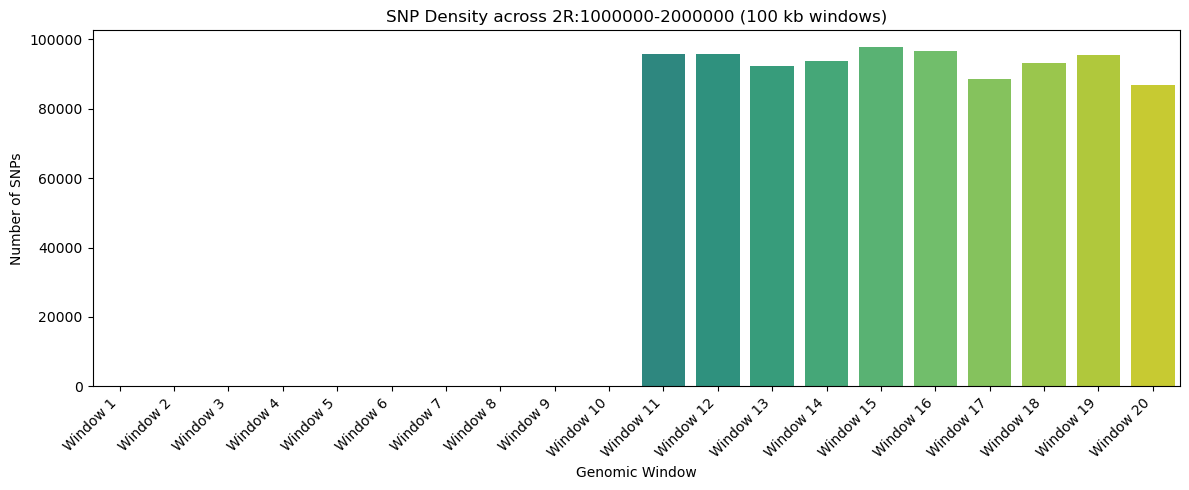

In [21]:
plt.figure(figsize=(12, 5))
sns.barplot(x=window_labels, y=hist, palette='viridis')
plt.title(f'SNP Density across {region} (100 kb windows)')
plt.xlabel('Genomic Window')
plt.ylabel('Number of SNPs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
allele_counts = allel.GenotypeArray(filtered_gt).count_alleles()
allele_frequencies = allele_counts.to_frequencies()
mafs = allel.moving_mean(np.min(allele_frequencies, axis=1), size=100)

ValueError: x and y must have same first dimension, but have shapes (935618,) and (9356,)

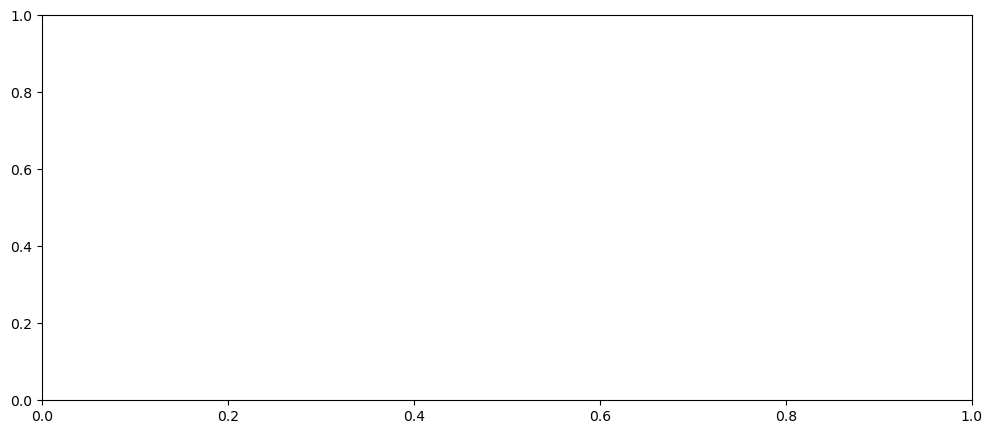

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(callset['variant_position'].values[filtered_variants_idx], mafs)
plt.title(f'MAF distribution along {region}')
plt.xlabel('Genomic Position')
plt.ylabel('MAF')
plt.axhline(0.05, color='r', linestyle='--', label='MAF = 5%')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
num_snps_for_ld = 200
snp_idx_for_ld = np.random.choice(snp_df.shape[1], size=num_snps_for_ld, replace=False)
snp_subset = snp_df.iloc[:, snp_idx_for_ld]

In [25]:
gt_ld = allel.GenotypeArray(filtered_gt[:, snp_idx_for_ld, :])
r2, _ = allel.rogers_huff_r2(gt_ld.T)

IndexError: index 558851 is out of bounds for axis 1 with size 100

In [26]:
plt.figure(figsize=(10, 10))
sns.heatmap(r2, cmap='viridis', square=True, cbar_kws={'label': 'r²'})
plt.title(f'Linkage Disequilibrium (r²) for a subset of {num_snps_for_ld} SNPs')
plt.xlabel('SNP Index')
plt.ylabel('SNP Index')
plt.tight_layout()
plt.show()

NameError: name 'r2' is not defined

<Figure size 1000x1000 with 0 Axes>

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(snp_df)

In [28]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=snp_df.index)

In [29]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_tsne, columns=['tSNE1', 'tSNE2'], index=snp_df.index)

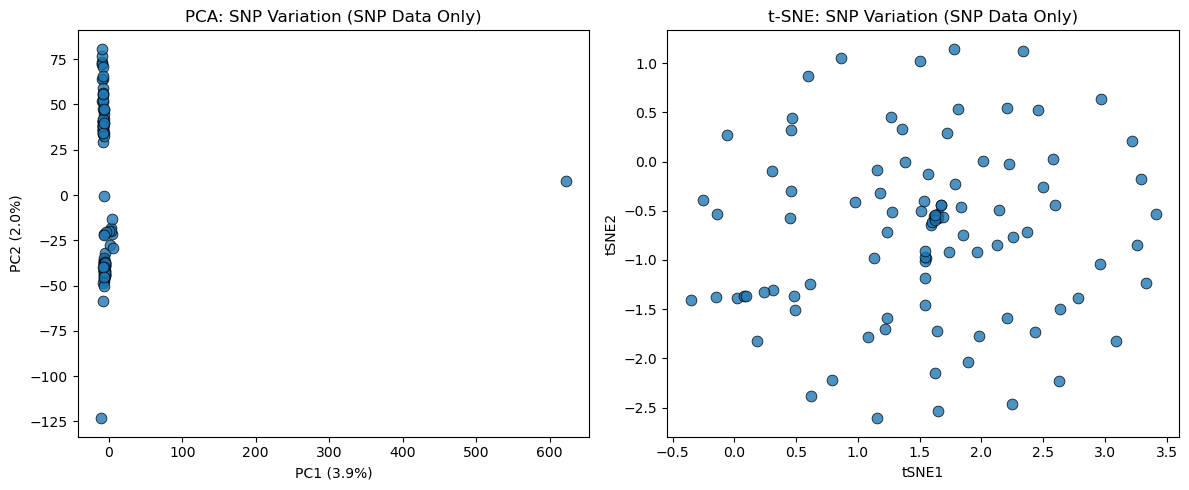

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', s=60, edgecolor='k', alpha=0.8)
plt.title('PCA: SNP Variation (SNP Data Only)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')

plt.subplot(1, 2, 2)
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', s=60, edgecolor='k', alpha=0.8)
plt.title('t-SNE: SNP Variation (SNP Data Only)')
plt.tight_layout()
plt.show()